In [128]:
from class_dataset import CTA_Data
from class_gcnn import GCN

import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
from pyproj import CRS
import torch
from torch.utils.data import DataLoader
import util_eval

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.rcParams.update({'font.size': 16})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
period='before'
conv_type='con'
lookback=4
ii=1
n_features=2
n_stations=143
z=1.96
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [130]:
saved = torch.load("../models/202012_graph/"+period+"_"+conv_type+"_"+str(lookback)+"_"+str(ii)+".pt")
lookback, dropout, n_hid_units, weight_decay = saved['hyperparameters']
net = GCN(nin=n_features, nout=n_stations, nhid_g=n_hid_units, nhid_l=n_hid_units, nlstm=1, 
              nhid_fc=n_hid_units, dropout=dropout)
net.load_state_dict(saved['model_state_dict'])
net = net.to(device)

In [131]:
with open("../data/data_processed/"+period+"_"+str(lookback)+"_data_test.pkl","rb") as f:
    x_test = pkl.load(f)
    ref_test = pkl.load(f)
    y_test = pkl.load(f)
    ts_test = pkl.load(f)

In [132]:
testset = CTA_Data(torch.Tensor(x_test), torch.Tensor(y_test), torch.Tensor(ref_test))
testloader = DataLoader(testset, batch_size = 256, shuffle=False, num_workers=10)

In [133]:
# construct adjacency matrix
with open("../data/data_processed/adj_neighbour_model.pkl", "rb") as f:
    adj = pkl.load(f)
    station_ids = pkl.load(f)
    
adj = torch.Tensor(adj).to(device)

In [134]:
adj.shape

torch.Size([143, 143])

In [135]:
test_out_mean, test_out_std = util_eval.testset_output(testloader, net, adj, device)
test_res = y_test - test_out_mean

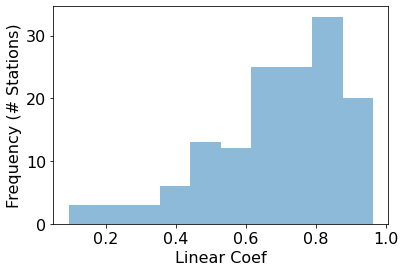

In [136]:
plt.hist(net.history_weights_mean.cpu().detach().numpy(), alpha=0.5)
plt.xlabel('Linear Coef')
plt.ylabel('Frequency (# Stations)')
plt.savefig("../figures/20201201/"+period+"_dist_linear_parameter.png", bbox_inches='tight');

Plotting station with max flow:  86


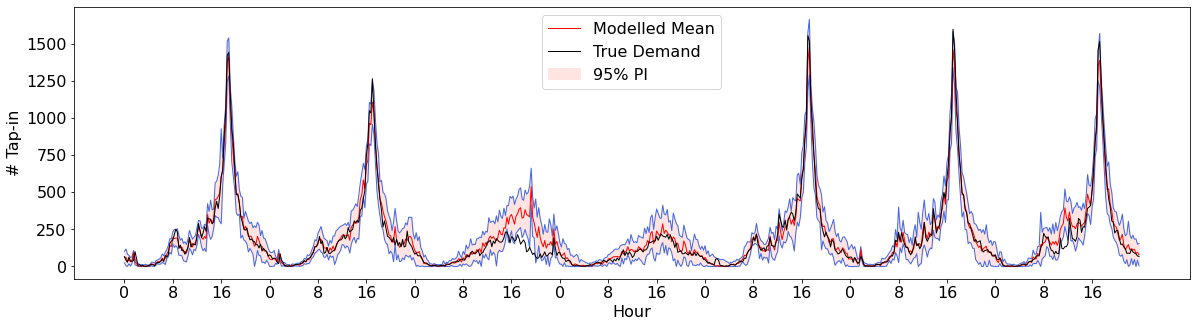

In [137]:
# station with maximum demand to plot time series
plot_station = np.argmax(np.mean(y_test, axis=0), axis=None)
st = (ts_test.min()//96+1)*96-ts_test.min()
duration = 672
print("Plotting station with max flow: ", plot_station)
fig, ax = plt.subplots(figsize=(20,5))
ax.fill_between(ts_test[st:st+672], np.maximum(test_out_mean[:, plot_station]-z*test_out_std[:, plot_station],0)[st:st+672],
               (test_out_mean[:, plot_station]+z*test_out_std[:, plot_station])[st:st+672],color='mistyrose', label='95% PI')
ax.plot(ts_test[st:st+672], np.maximum(test_out_mean[:, plot_station]-z*test_out_std[:, plot_station],0)[st:st+672], linewidth=1, color='royalblue')
ax.plot(ts_test[st:st+672], (test_out_mean[:, plot_station]+z*test_out_std[:, plot_station])[st:st+672], linewidth=1, color='royalblue')
ax.plot(ts_test[st:st+672],test_out_mean[:, plot_station][st:st+672], linewidth=1, color='red', label='Modelled Mean')
ax.plot(ts_test[st:st+672],y_test[:, plot_station][st:st+672], linewidth=1, color='k', label='True Demand')
ax.set_xticks(np.arange(ts_test.min()+st, ts_test.min()+st+672, 32))
ax.set_xticklabels(np.arange(ts_test.min()+st, ts_test.min()+st+672, 32) % 96 // 4)
ax.set_xlabel('Hour')
ax.set_ylabel('# Tap-in')
ax.legend();

Plotting station with max flow:  49


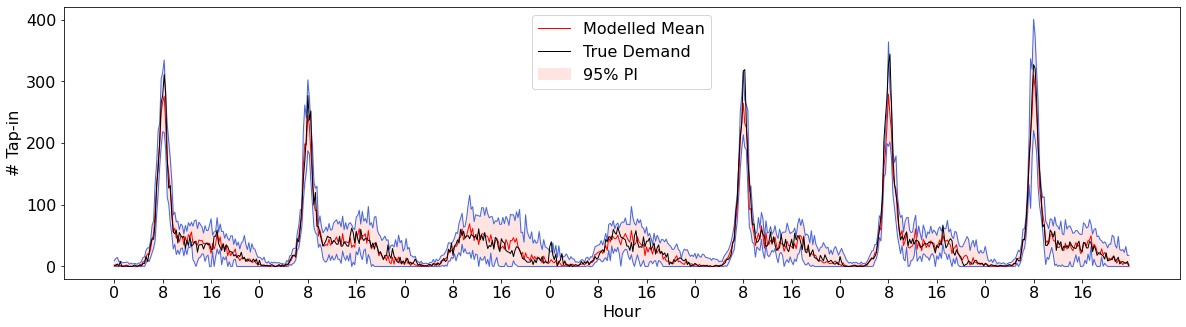

In [138]:
# station with maximum demand to plot time series
plot_station = 49
st = (ts_test.min()//96+1)*96-ts_test.min()
duration = 672
print("Plotting station : ", plot_station)
fig, ax = plt.subplots(figsize=(20,5))
ax.fill_between(ts_test[st:st+672], np.maximum(test_out_mean[:, plot_station]-z*test_out_std[:, plot_station],0)[st:st+672],
               (test_out_mean[:, plot_station]+z*test_out_std[:, plot_station])[st:st+672],color='mistyrose', label='95% PI')
ax.plot(ts_test[st:st+672], np.maximum(test_out_mean[:, plot_station]-z*test_out_std[:, plot_station],0)[st:st+672], linewidth=1, color='royalblue')
ax.plot(ts_test[st:st+672], (test_out_mean[:, plot_station]+z*test_out_std[:, plot_station])[st:st+672], linewidth=1, color='royalblue')
ax.plot(ts_test[st:st+672],test_out_mean[:, plot_station][st:st+672], linewidth=1, color='red', label='Modelled Mean')
ax.plot(ts_test[st:st+672],y_test[:, plot_station][st:st+672], linewidth=1, color='k', label='True Demand')
ax.set_xticks(np.arange(ts_test.min()+st, ts_test.min()+st+672, 32))
ax.set_xticklabels(np.arange(ts_test.min()+st, ts_test.min()+st+672, 32) % 96 // 4)
ax.set_xlabel('Hour')
ax.set_ylabel('# Tap-in')
ax.legend();

In [139]:
spatial_mean=np.nanmean(y_test, axis=0)
modelled_mean=np.nanmean(test_out_mean, axis=0)
modelled_var=np.nanmean(test_out_std, axis=0)
res = np.nanmean(test_res, axis=0)

df = pd.DataFrame(np.array([station_ids, spatial_mean, modelled_mean, modelled_var, res]).T, 
                  columns=['station_id','obs_mean','model_mean','model_var','residual'])

In [140]:
stations = gpd.read_file('../data/data_raw/CTA_Rail/CTA_RailStations.shp')
stations = stations.to_crs(CRS("epsg:4326"))

In [141]:
def plot_output_spatial(stations, df, merge_cols_left, merge_cols_right, value_col, title, cmap, scale=(5,30)):

    temp = pd.merge(stations, df, left_on=merge_cols_left, right_on=merge_cols_right)
    scheme = mc.Quantiles(temp[value_col], k=5)
    # get all upper bounds
    upper_bounds = scheme.bins
    # get and format bounds
    bounds = []
    for index, upper_bound in enumerate(upper_bounds):
        if index == 0:
            lower_bound = df[value_col].min()
        else:
            lower_bound = upper_bounds[index-1]

        # format the numerical legend here
        bound = f'{lower_bound:.0f} - {upper_bound:.0f}'
        bounds.append(bound)

    chicago = (stations.geometry.x.min(), stations.geometry.y.min(),
               stations.geometry.x.max(), stations.geometry.y.max())
    downtown = (-87.645168, 41.872034, -87.623921, 41.889749)
    contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))
    a = gplt.pointplot(temp, projection=gcrs.WebMercator(), cmap=cmap,
                  hue=value_col, scale=value_col, limits=scale, scheme=scheme, extent=chicago, legend=False)
    gplt.webmap(contiguous_usa, projection=gcrs.WebMercator(), ax=a, extent=chicago)
    # this patch won't show up with webmap, need to investigate further
    #gplt.gca().add_patch(Rectangle((-87.645168, 41.872034),0.021247,0.017715,linewidth=5,edgecolor='r',facecolor='r'))
    # this does not work either, cannot overlay polygon on webmap, seems that only pointplot works.
    #a = gplt.polyplot(poly, projection=gcrs.WebMercator(), extent=chicago) 
    plt.title(title)
 
    plt.savefig("../figures/20201201/"+period+"_"+value_col+".png",bbox_inches='tight')
    a = gplt.pointplot(temp, projection=gcrs.WebMercator(), hue=value_col, scale=value_col, limits=scale,
                       scheme=scheme, legend=True, legend_var='hue',cmap=cmap,
                  legend_kwargs={'bbox_to_anchor': (1, 0.5), 'frameon': True})
    gplt.webmap(contiguous_usa, projection=gcrs.WebMercator(), ax=a, extent=downtown)
    plt.title('Downtown Zoom')
   # get all the legend labels
    legend_labels = a.get_legend().get_texts()

    # replace the legend labels
    for bound, legend_label in zip(bounds, legend_labels):
        legend_label.set_text(bound)
 
    plt.savefig("../figures/20201201/"+period+"_"+value_col+"_downtown.png", bbox_inches='tight')

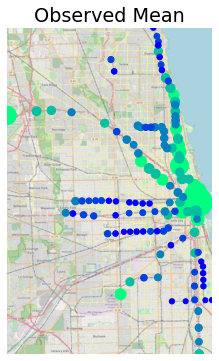

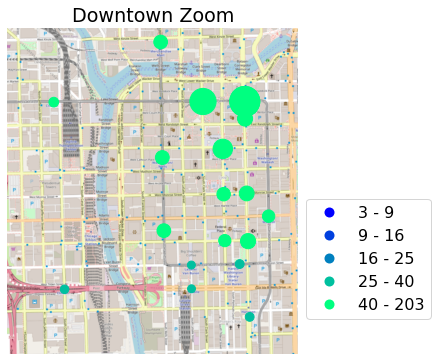

In [142]:
plot_output_spatial(stations, df, merge_cols_left='STATION_ID', merge_cols_right='station_id', 
                              value_col='obs_mean', title='Observed Mean', cmap='winter')


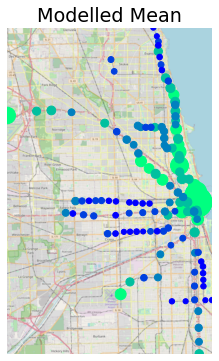

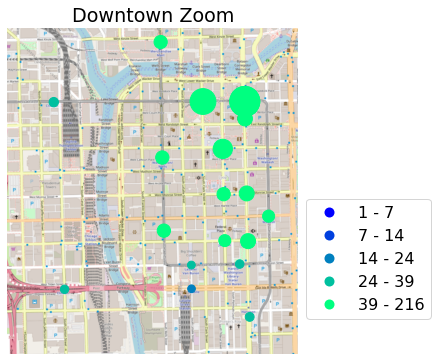

In [143]:
plot_output_spatial(stations, df, merge_cols_left='STATION_ID', merge_cols_right='station_id', 
                              value_col='model_mean', title='Modelled Mean', cmap='winter')

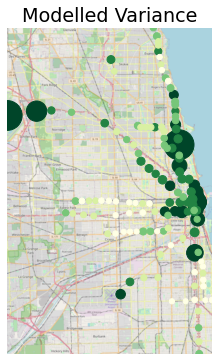

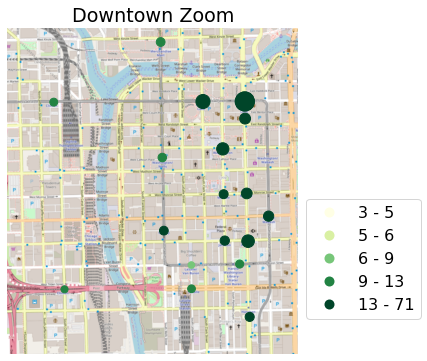

In [144]:
plot_output_spatial(stations, df, merge_cols_left='STATION_ID', merge_cols_right='station_id', 
                              value_col='model_var', title='Modelled Variance', cmap='YlGn')

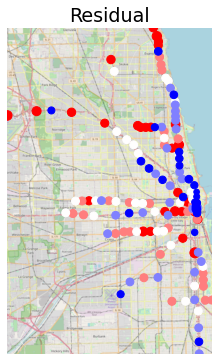

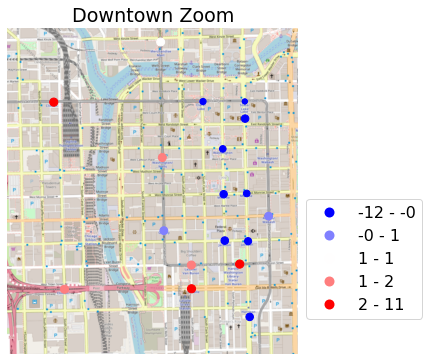

In [145]:
plot_output_spatial(stations, df, merge_cols_left='STATION_ID', merge_cols_right='station_id', 
                              value_col='residual', title='Residual', cmap='bwr', scale=(5,10))

In [146]:
diff = np.abs(ref_test - y_test) / y_test

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [147]:
mask = (diff > 0.5).flatten()
y_test_high = y_test.flatten()[mask]
ref_test_high = ref_test.flatten()[mask]
test_out_mean_high = test_out_mean.flatten()[mask]
test_out_std_high = test_out_std.flatten()[mask]
print(np.sum(mask) / len(y_test.flatten()))
print(util_eval.eval_mean(test_out_mean_high, y_test_high))
print(util_eval.eval_mean(ref_test_high, y_test_high))

0.2953859865624571
(8.239325365661305, 533.3894091794212)
(10.723076476732041, 765.4464720900545)


/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [148]:
mask = (diff > 1).flatten()
y_test_high = y_test.flatten()[mask]
ref_test_high = ref_test.flatten()[mask]
test_out_mean_high = test_out_mean.flatten()[mask]
test_out_std_high = test_out_std.flatten()[mask]
print(np.sum(mask) / len(y_test.flatten()))
print(util_eval.eval_mean(test_out_mean_high, y_test_high))
print(util_eval.eval_mean(ref_test_high, y_test_high))

0.11611305361305362
(9.295031992008795, 826.8583910896784)
(12.755258690678279, 1256.7745959111373)


/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
